
## Demonstration of a few new features in the FFT MTF Map-branch

In [1]:
# a few minimal imports and getting logging up
import pathlib, sys, logging, os
logging.basicConfig(handlers = [logging.FileHandler(filename = (
                    pathlib.Path.home() / 'Desktop' / 'zospy-coherent_log.txt'), 
                    encoding='utf-8')], level=logging.DEBUG )

In [6]:
# add whatever path neccessary to find your checkout of ZOSPy or set 'zospydevpath
if 'zospydevpath' in os.environ:
    zpdevpath = os.environ['zospydevpath']
else:
    zpdevpath = pathlib.Path(r"C:\Users\...")
    print('Define user Variable "zospyuserdevpath" or change line in the else branch in this cell')
    
if not (str(zpdevpath) in sys.path):
    sys.path.append(str(zpdevpath))
import zospy as zp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# additional stuff needed in this demo but not beeing main topic
import clr
clr.AddReference("System.Windows.Forms")
from System.Windows import Forms as dotnetforms #  We are on Windows and .net is there
fd = dotnetforms.OpenFileDialog()
fd.title = "Go to the Example simple_scanner.zos and open it"

### loading ZOSPy, (dis-)connecting to|from OpticStudio

In [8]:
zos = zp.ZOS()

In [19]:
oss = zos.connect(mode="extension")
# now the status of OpticStudio should change from "waiting for connection" to "connnected"

In [36]:
zos.disconnect()
# makes oss object obsolete but doesn't destroy it

### now OpticStudio should be connected

In [14]:
# Show File Dialog
# Probably you have to press <shift>+<alt>+<tab> to see the dialog
# This happens to be a "pop-under" from jupyter
ret = fd.ShowDialog()
strFile = fd.FileName
plFile = pathlib.Path(strFile)

In [20]:
oss.load(strFile)

In [23]:
# get a MCE, set the current configuration
oss.MCE.SetCurrentConfiguration(1)

True

### some added features in the Lens Data Editor
Since surface numbers are likely to change during design phase, it is sometimes handy to reference surfaces by their comment.
LDE has new Methods .SurfaceByComment() and .SurfaceByRegex() to do so

In [24]:
# get the galvo mirror surfaces
# x|y_mir are instances of 
lde = oss.LDE
x_mir = lde.SurfaceByComment('x-mirror')
print(x_mir.Comment)
print(f"has surface number: {x_mir.SurfaceNumber}")
y_mir = lde.SurfaceByRegex(r'y-.*')
print(y_mir.Comment)
print(f"has surface number: {y_mir.SurfaceNumber}")

x-mirror
has surface number: 4
y-angle
has surface number: 8


In [25]:
lde.InsertNewSurfaceAt(5)
# after adding a new surface, surface numbers change

In [26]:
# but we still get the same surfaces
x_mir = lde.SurfaceByComment('x-mirror')
print(f"x-mirror has surface number: {x_mir.SurfaceNumber}")
y_mir = lde.SurfaceByRegex(r'y-.*')
print(f"y-mirror has surface number: {y_mir.SurfaceNumber}")

x-mirror has surface number: 4
y-mirror has surface number: 9


## Now a little more advanced Analysis
mtfclasses offers object oriented access to the analysis windows.
After setting up the Analysis window the actual analysis has to be triggered
by .Apply() or .ApplyAndWaitForCompletion(). 
Analysis can then be run consecutivly for different configs or changed parameters.

Use case is a galvo scanner system to move a laser|sensor over a workpiece.
But there is also a coaxial camera moving with the laser|sensor


In [27]:
# look for an existing analysis tab, in order not to fill up Zemax-GUI with dozens of new tabs
# List of opened analyses (first item None aligning the list-index with indexes to be used by _System.Analyses.GetAnalysisAt() 
for ana in oss.opened_analyses:
    print(ana)
# get FftMtfMap analyses
list_fftmtfmap = oss.get_analyses_of_type(zp.constants.Analysis.AnalysisIDM.FftMtfMap)
print("*****************")
for ana in list_fftmtfmap:
    print(ana)
# in case there is no FFT MTF MAP already open, open it.
if len(list_fftmtfmap) == 0:
    base_fftmtfmap = oss.Analyses.New_Analysis(zp.constants.Analysis.AnalysisIDM.FftMtfMap)
else:
    base_fftmtfmap = list_fftmtfmap[-1]

None
*****************


In [28]:
# now we have an object instance of a bare ZOS-API "FFT MTF MAP"-tab
print(base_fftmtfmap)

ZemaxUI.ZOSAPI.Analysis.Mtf.A_FftMtfMap


In [29]:
# for the time beeing the ZOSPy instance has to be made from a base analysis
# maybe in future versions ZOSPy will return an enhanced Version of the Analysis directly
fftmtfmap = zp.analyses.mtfclasses.FFT_MTF_MAP(base_fftmtfmap)
sets = fftmtfmap.Settings
res = fftmtfmap.Results

In [30]:
# now we could disconnect from OpticStudio change settings in the GUI
# and get our hands on those settings programmatically
print(sets.SampleSize)
print(sets.X_Pixels)
print(sets.MTF_DataType)
print(sets.Frequency)
print(sets.X_Field_Width, sets.Y_Field_Width)
# make sure to reconnect and reinstanciate above objects before continuing

S_64x64
5
Average
10.0
0.0 0.0


In [31]:
# these setting should show some of the blurriness of the camerapicture while scanning
sets.SampleSize = zp.constants.Analysis.SampleSizes.S_64x64
sets.X_Pixels, sets.Y_Pixels = (21,21)
sets.MTF_DataType = zp.constants.Analysis.Settings.Mtf.MtfDataTypes.Sagittal
sets.Frequency = 10
(sets.X_Field_Width, sets.Y_Field_Width) = (10., 10.)


In [32]:
# make the analysis and retrieve the results
fftmtfmap.ApplyAndWaitForCompletion()
grid = res.DataGrids[0]  # grid.Values is a clr System.Double[,] !
# System.Double[] cannot be accessed completely straight forward
# There is some magic inside numpy involved to make the following happen
npMap = np.array(grid.Values) #
print(f"type:{type(npMap)}    shape:{npMap.shape}"  )     

type:<class 'numpy.ndarray'>    shape:(21, 21)


Text(0.5, 1.0, 'sag-data, frequency @workpiece: 10.0 cyc/mm, samp64')

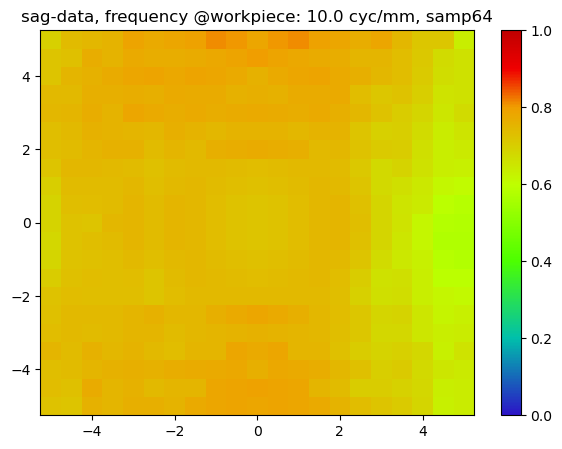

In [33]:
# now we have the values nicely organized in numpy array we can plot them
# span a meshgrid to align the values
xes = np.arange(grid.MinX, grid.MinX+((grid.Nx-0.5)*grid.Dx), grid.Dx)
ys = np.arange(grid.MinY, grid.MinY+((grid.Ny-0.5)*grid.Dy), grid.Dy)
Xmesh, Ymesh = np.meshgrid(xes, ys)

fig, ax= plt.subplots(figsize=(7,5))
levels = np.arange(0.,1.001, 0.01)
# for the sake of sanity, try to keep the colorscale similar to OpticStudio
CS = ax.pcolormesh(Xmesh, Ymesh, npMap, 
                   cmap = fftmtfmap.os_color_map, # ZOSPy has some helpers to do that
                   norm = fftmtfmap.cmap_norm)
cbar = fig.colorbar(CS)

if sets.MTF_DataType == zp.constants.Analysis.Settings.Mtf.MtfDataTypes.Sagittal:
    mtfdatastr = "sag"
elif sets.MTF_DataType == zp.constants.Analysis.Settings.Mtf.MtfDataTypes.Tangential:
    mtfdatastr = "tan"
else:
    mtfdatastr = "wrong"
ax.set_title(
            f"{mtfdatastr}-data, frequency @workpiece: {sets.Frequency} cyc/mm, samp{sets.SampleSize.ToString().split('x')[1]}")

In [34]:
# now we can loop over various parameters of the system and make plots
# Best show, if tabs, splitting in OS is aranged in a way, that the Tilt About X
# and the FFT MTF Map are visible
# The y-galvo is scanning 
# Just 5 angles in this example. Use matplotlibs.savefig and probably 
# connect(mode = "standalone") if more plots are neccessary 

# get the y-mirror turning angle
lde = oss.LDE
y_ang = lde.SurfaceByRegex(r'(?i:y.ang).*')
# pick the Editor Cell. "Tilt About X" is cell 14
angle_cell = y_ang.GetCellAt(14) # Maybe there should be a GetCellByHeader() method

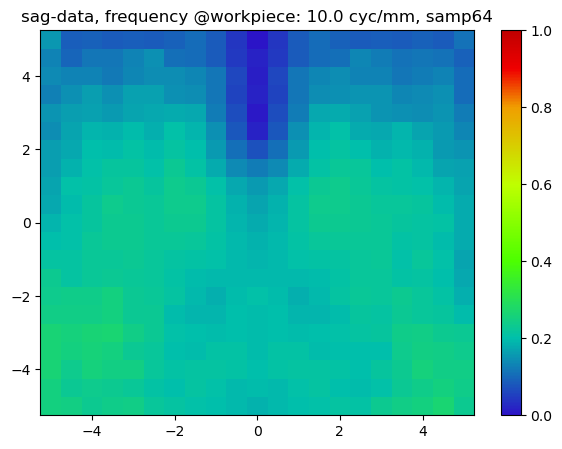

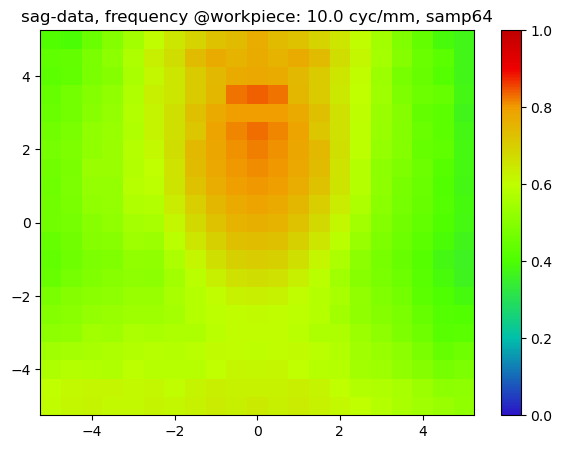

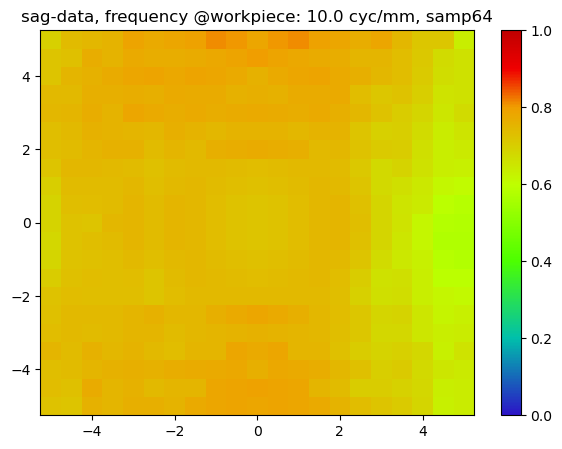

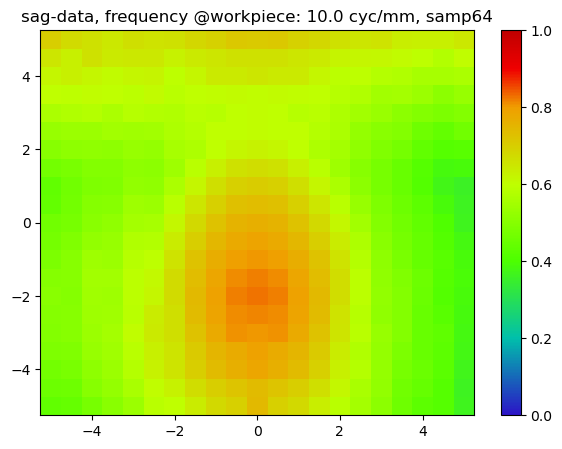

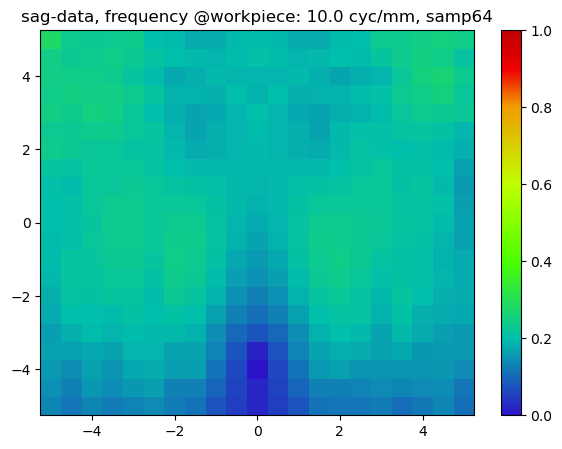

In [35]:
yangles = np.arange(-51, -38.5, 3.)
levels = np.arange(0.,1.001, 0.01)
once = True
for yang in yangles:
    angle_cell.DoubleValue = yang
    fftmtfmap.ApplyAndWaitForCompletion()
    grid = res.DataGrids[0]
    npMap = np.array(grid.Values)
    
    fig, ax= plt.subplots(figsize=(7,5))
    CS = ax.pcolormesh(Xmesh, Ymesh, npMap, 
        cmap = fftmtfmap.os_color_map, # ZOSPy has some helpers to do that
        norm = fftmtfmap.cmap_norm)
    cbar = fig.colorbar(CS) 

    if sets.MTF_DataType == zp.constants.Analysis.Settings.Mtf.MtfDataTypes.Sagittal:
        mtfdatastr = "sag"
    elif sets.MTF_DataType == zp.constants.Analysis.Settings.Mtf.MtfDataTypes.Tangential:
        mtfdatastr = "tan"
    else:
        mtfdatastr = "wrong"
    ax.set_title(
        f"{mtfdatastr}-data, frequency @workpiece: {sets.Frequency} cyc/mm, samp{sets.SampleSize.ToString().split('x')[1]}")


In [23]:
angle_cell.Value
dir(angle_cell)
angle_cell.Header

'Tilt About X'